In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
import time


from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:

import os

folder_path = "D://BISM/dataset/Dataset/Breast scans/benign/Train/"

# Get a list of all files in the folder
# Get a list of all files in the folder
files = os.listdir(folder_path)

# Loop through the files and delete any image files that contain the word "mask" in their name
for file in files:
    if file.lower().endswith(('.png', '.jpg')) and "mask" in file.lower():
        os.remove(os.path.join(folder_path, file))

In [ ]:
import zipfile
path = '/content/Dataset.zip'
zip_obj = zipfile.ZipFile(file=path,mode='r')
zip_obj.extractall('./')
zip_obj.close()

creating a data generator for image classification tasks. The function takes a path to a directory containing the training images as input. Here's a brief summary of what the function does:

Creates a training dataset using the tf.keras.preprocessing.image_dataset_from_directory() function.

Creates a data generator for training images using the ImageDataGenerator() function and the flow_from_directory() method.

Creates a data generator for validation images using the same ImageDataGenerator() function and the flow_from_directory() method, with the subset argument set to 'validation'.

Gets the number of classes in the dataset and the names of the classes from the training dataset.

Displays a sample of the images from the training dataset.
Returns the number of classes, class names, training data generator, and validation data generator.

In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

applies normalization to the training and validation datasets. It assumes that the train_generator and val_generator data generators have already been created using ImageDataGenerator() and flow_from_directory() methods.

Here's what the function does:

Defines a constant AUTOTUNE to be used with TensorFlow's data pipeline API for performance optimization.

Caches the training dataset in memory and shuffles it, then prefetches data to improve the data pipeline performance.

Caches the validation dataset and prefetches data as well.

Defines a Rescaling() layer from the layers module of Keras/TensorFlow, which scales the input image pixel values between 0 and 1.

Applies the Rescaling() layer to the normalized dataset using the map() method 
of TensorFlow's Dataset class.



In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))


creates a deep learning model based on the ResNet50V2 architecture, which is a popular pre-trained model for image classification tasks. The function takes an input argument noOfClasses which specifies the number of output classes in the classification problem.

Here's what the function does:

Initializes the modelInput variable with a pre-trained ResNet50V2 model from the Keras/TensorFlow applications module.

Sets all layers of the pre-trained model to be non-trainable to prevent their weights from being updated during the training process.

Adds a Flatten() layer after the output of the pre-trained model to convert the 2D output feature map to a 1D feature vector.

Adds a fully connected Dense() layer with a softmax activation function to perform the final classification task, where the output of the layer is a probability distribution over the noOfClasses output categories.

Creates a new Model object by specifying the input and output tensors of the model.
Returns the newly created model object.

In [4]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

 initializes some important parameters used for training the deep learning model.



Initializes the optimizer used for training the model. In this case, the Adam optimizer is used with a learning rate specified by the input parameter lr.
Compiles the model by specifying the optimizer, loss function, and evaluation metrics. The loss function is set to 'categorical_crossentropy' since it's a multi-class classification problem.

Initializes the ReduceLROnPlateau callback, which is used to dynamically adjust the learning rate during training based on the validation accuracy of the model. This callback monitors the validation accuracy and reduces the learning rate by a factor of 0.5 if the validation accuracy doesn't improve for patience number of epochs.

Initializes the ModelCheckpoint callback, which is used to save the best model during training based on the validation loss. The saved model is named after the input parameter className and has the file extension .h5.
Returns the compiled model object, the ReduceLROnPlateau callback object, and the ModelCheckpoint callback object.

In [5]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'ResNet50V2.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [ ]:
# def initiateParams(className, model, lr):
#     opt = tf.keras.optimizers.Adam(learning_rate=lr)

#     # Add L2 regularization to the model
#     reg = tf.keras.regularizers.l2(0.01)
#     for layer in model.layers:
#         if hasattr(layer, 'kernel_regularizer'):
#             layer.kernel_regularizer = reg

#     # Use data augmentation
#     train_datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

#     annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    
#     # Add early stopping
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#     model.compile(optimizer=opt,
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     checkpoint = ModelCheckpoint(className + 'ResNet50V2.h5', verbose=1, save_best_only=True)
    
#     return model, annealer, checkpoint


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [8]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evalModel(model):
    evaluation = model.evaluate(validation_generator)
    accuracy = evaluation[1] * 100
    
    y_true = validation_generator.classes
    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f_score = f1_score(y_true, y_pred, average='macro')
    
    conf_mat = confusion_matrix(y_true, y_pred)
    
    msg = f'Accuracy on the Test Set = {accuracy:5.2f} %\n'
    msg += f'Precision = {precision:5.2f}\n'
    msg += f'Recall = {recall:5.2f}\n'
    msg += f'F-score = {f_score:5.2f}\n'
    
    print(msg)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(conf_mat)
    ax.grid(False)
    ax.set_xlabel('Predicted labels', fontsize=12, color='black')
    ax.set_ylabel('True labels', fontsize=12, color='black')
    ax.xaxis.set(ticks=range(len(class_names)))
    ax.yaxis.set(ticks=range(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=10, rotation=45)
    ax.set_yticklabels(class_names, fontsize=10)
    ax.set_ylim(len(class_names)-0.5, -0.5)
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='white', fontsize=12)
    plt.show()


In [10]:
mpath = r'/content/drive/MyDrive/Dataset'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    className = i
    print(className)

Brain scans
brain_breast
Breast scans



Total :  Found 1209 files belonging to 2 classes.

For Training :  Found 968 images belonging to 2 classes.

For Val :  Found 241 images belonging to 2 classes.

No of Classes :  2
Classes :  ['brain', 'breast']
Image Shape :  (32, 256, 256, 3)
94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                

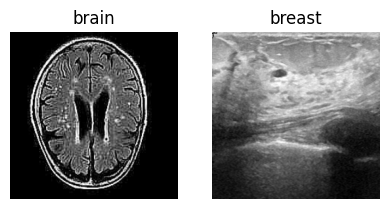

In [11]:
import time
start_time = time.time()

className = 'brain_breast'
cpath = os.path.join(mpath, 'brain_breast')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time, " seconds")

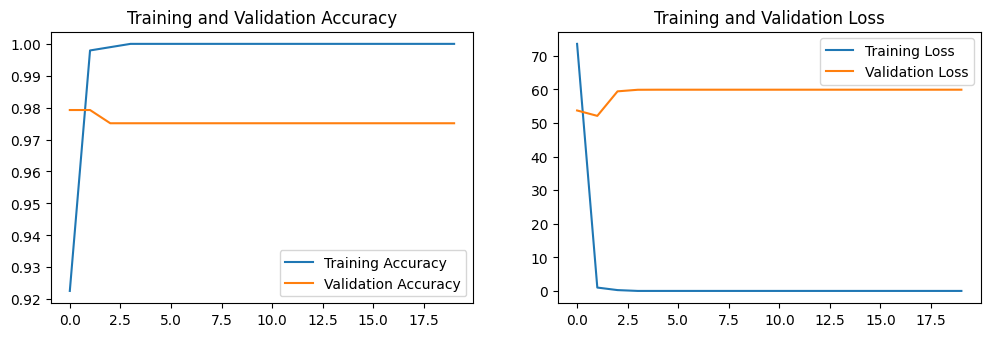

8/8 [==============================] - 4s 327ms/step
Accuracy on the Test Set = 97.51 %
Precision =  0.98
Recall =  0.97
F-score =  0.98



<Figure size 640x480 with 0 Axes>

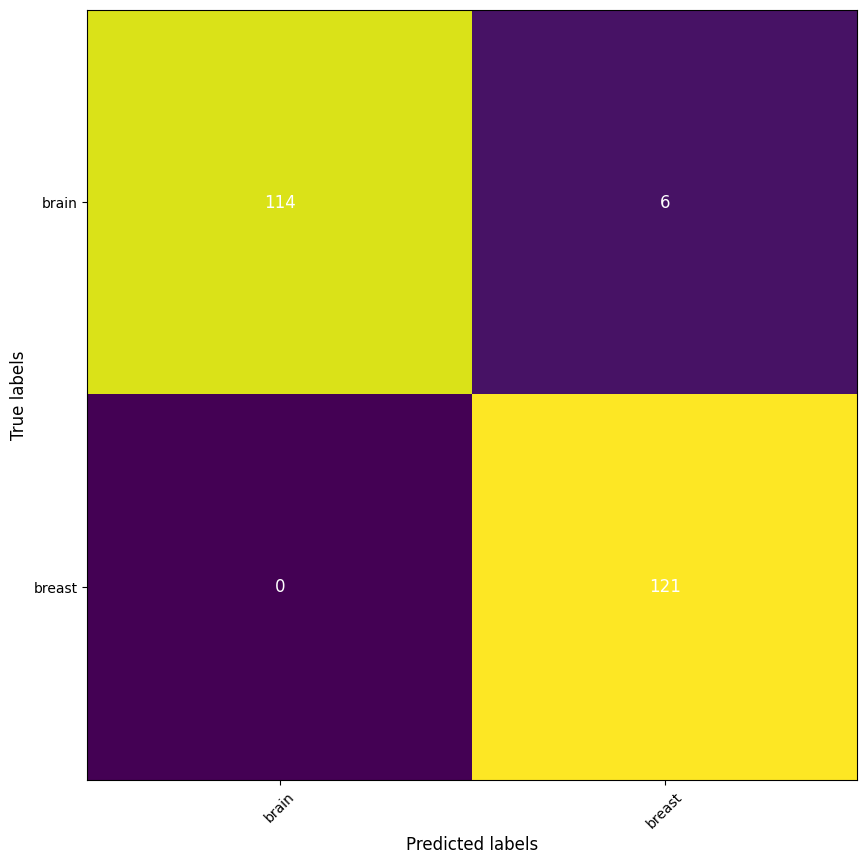

In [12]:
plotOutput(curHistory, 'brain_breast', gEpochs)
evalModel(curModel)


In [13]:
from keras.models import load_model

model = load_model('/content/brain_breastResNet50V2.h5')

In [14]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

model = load_model('/content/brain_breastResNet50V2.h5')

img = load_img('/content/drive/MyDrive/Dataset/brain_breast/breast/test/benign (399).png', target_size=(224, 224))

img_array = img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array = preprocess_input(img_array)

prediction = model.predict(img_array)

print(np.argmax(prediction))


1/1 [==============================] - 1s 1s/step
0



Total :  Found 1201 files belonging to 2 classes.

For Training :  Found 961 images belonging to 2 classes.

For Val :  Found 240 images belonging to 2 classes.

No of Classes :  2
Classes :  ['No tumor', 'Tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112

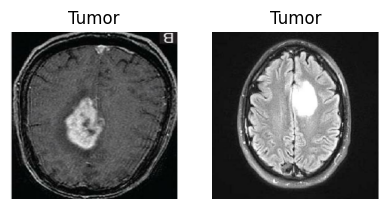

In [15]:
import time
start_time = time.time()

className = 'Brain scans'
cpath = os.path.join(mpath, 'Brain scans')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time, " seconds")

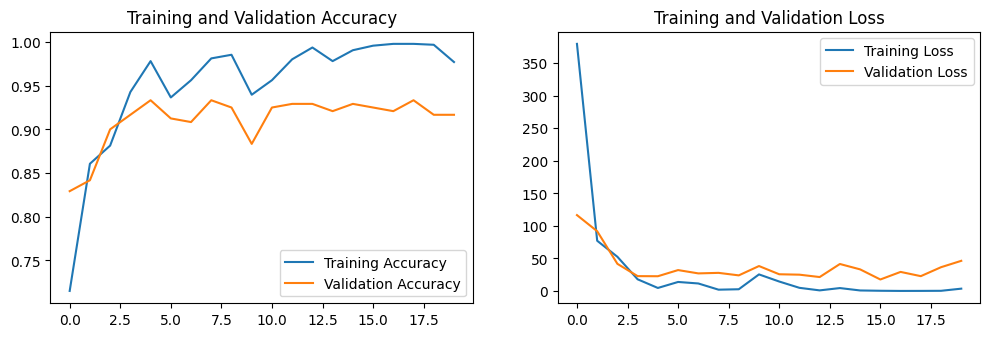

8/8 [==============================] - 2s 135ms/step
Accuracy on the Test Set = 91.67 %
Precision =  0.93
Recall =  0.92
F-score =  0.92



<Figure size 640x480 with 0 Axes>

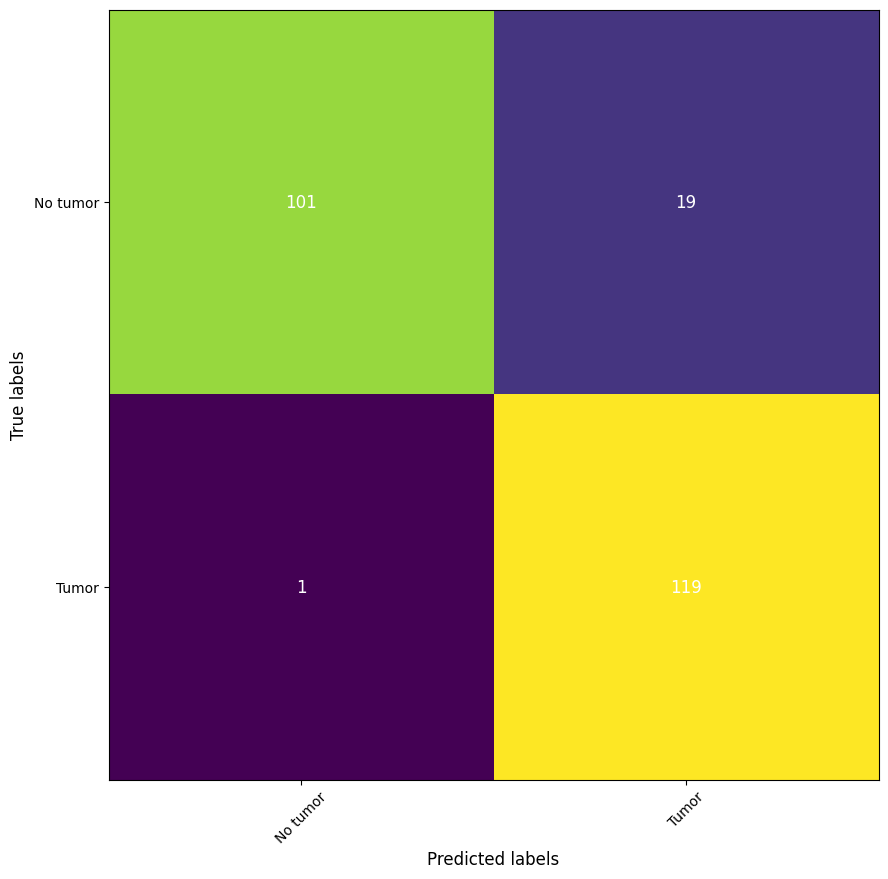

In [16]:
plotOutput(curHistory, 'Brain scans', gEpochs)
evalModel(curModel)


Total :  Found 792 files belonging to 3 classes.

For Training :  Found 635 images belonging to 3 classes.

For Val :  Found 157 images belonging to 3 classes.

No of Classes :  3
Classes :  ['benign', 'malignant', 'normal']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)           

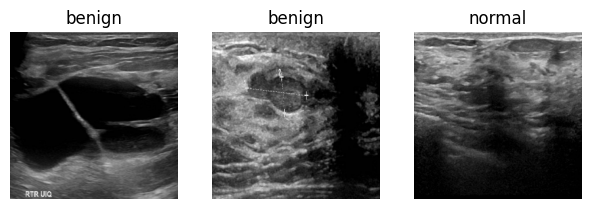

In [17]:
import time
start_time = time.time()

className = 'Breast scans'
cpath = os.path.join(mpath, 'Breast scans')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ", execution_time, " seconds")

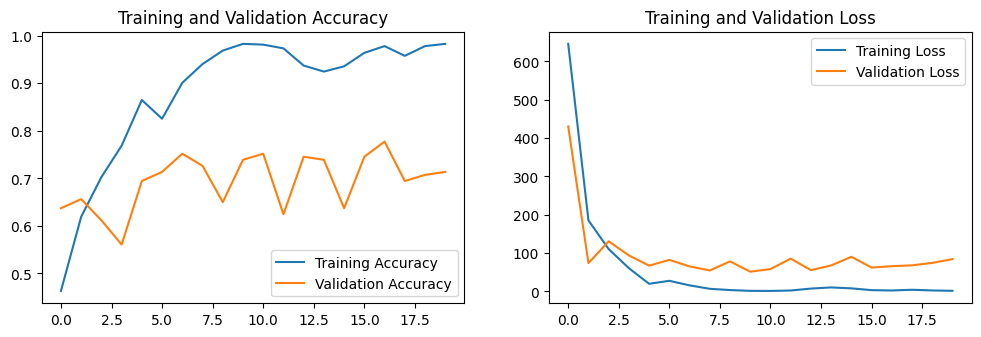

5/5 [==============================] - 3s 449ms/step
Accuracy on the Test Set = 71.34 %
Precision =  0.81
Recall =  0.56
F-score =  0.56



<Figure size 640x480 with 0 Axes>

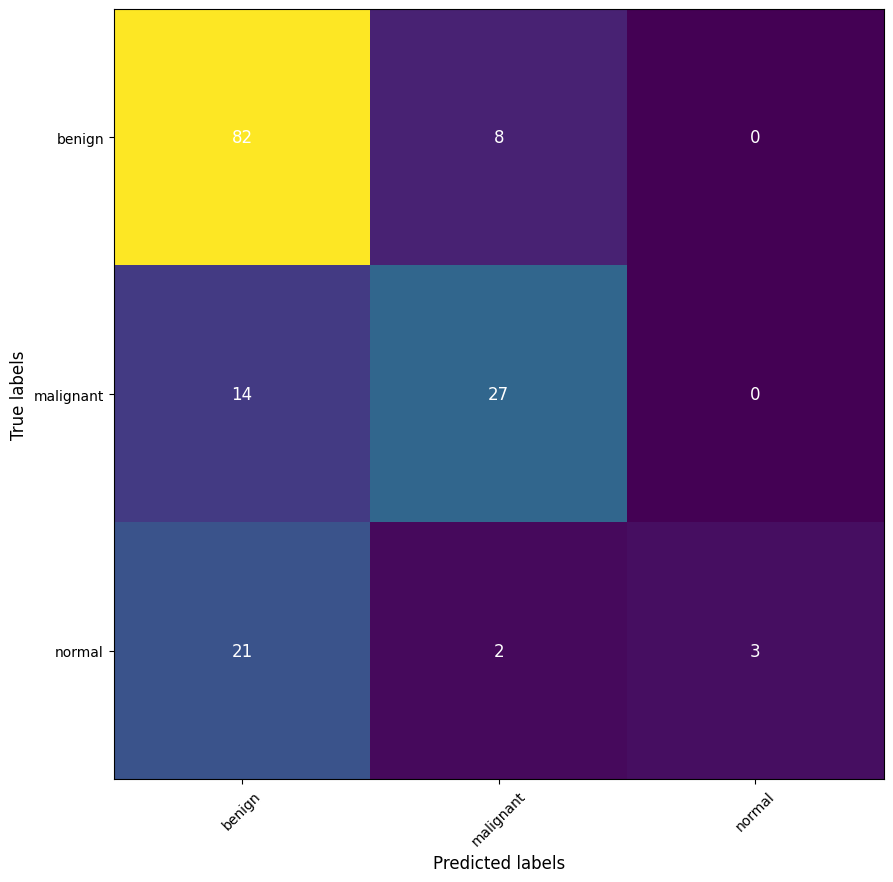

In [18]:
plotOutput(curHistory, 'Breast scans', gEpochs)
evalModel(curModel)